In [39]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Import Statsmodel Libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms


#Import sklearn  Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from IPython.display import display_html


#Set Display Options for Jupyter
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import pickle
with open('regression_Data_xref.pickle', 'rb') as file:
    df_Target_Homes_For_xref = pickle.load(file)

# Mics Supporting Functions

In [40]:
#sklearn
def CreateTrainTestSplit(df, columns):
    listofSplitTrain_DFs = []
    
    X = df[columns]
    y = df['log_price']
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train_No_ID = X_train.drop(['id'], axis = 1)
    
    X_test_No_ID = X_test.drop(['id'], axis = 1)
    
    listofSplitTrain_DFs.append(X_train)
    listofSplitTrain_DFs.append(X_test)
    listofSplitTrain_DFs.append(y_train)
    listofSplitTrain_DFs.append(y_test)
    listofSplitTrain_DFs.append(X_train_No_ID)
    listofSplitTrain_DFs.append(X_test_No_ID)
    
    return listofSplitTrain_DFs

def CreateModel_SK(X_train_No_ID, X_test_No_ID, y_train, y_test):
    listofValues = []
    listofAdjR = []
    listofdfs = []
  
    print(len(X_train_No_ID), len(X_test_No_ID), len(y_train), len(y_test))
    
    #Sklearn Features, Create Model
    linreg = LinearRegression()
    linreg.fit(X_train_No_ID, y_train)

    
    #Run Test
    y_hat_train = linreg.predict(X_train_No_ID)
    y_hat_test = linreg.predict(X_test_No_ID)
    
    # Collect Data into dataframe
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    train_R2 = round(linreg.score(X_train_No_ID,y_train),3)
    test_R2 = round(linreg.score(X_test_No_ID,y_test),3)
    
    listofAdjR.append(["train_R2",train_R2])
    listofAdjR.append(["test_R2",test_R2])
    df_listofAdjR = pd.DataFrame(listofAdjR, columns =['Measure', "Value"])
    df_listofAdjR.Value = df_listofAdjR.Value.apply(lambda x : "{:.3f}".format(x))
    
    listofValues.append(["train_mse", train_mse])
    listofValues.append(["test_mse",test_mse])
    listofValues.append(["intercept",linreg.intercept_])
    modelCoefficients = list(zip(X_train_No_ID.columns, linreg.coef_))
    listofValues = listofValues + modelCoefficients
    
    df = pd.DataFrame(listofValues, columns =['Measure', "Value"])
#     df.Value = df.Value.apply(lambda x : "{:,.0f}".format(x))
    
    
    df_listofAdjR1 = df_listofAdjR.append(df, ignore_index=True)
        
    return df_listofAdjR1, y_hat_train, y_hat_test

#StatsModel
def CreateModel_stats (y ,X_Train, Target_Features):
    predictors = X_Train[Target_Features]
    predictors_int = sm.add_constant(predictors)
    model = sm.OLS(y,predictors_int).fit()
    residuals = model.resid
#     return  model.summary(), residuals
    return  model, residuals

def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def RunQQplot (df_features, y_hat_data, NameOfPlot):
    df_features_copy = df_features.copy()
    
    df_features_copy.insert(0, 'log_price', y_hat_data)
    
    f = formula_from_cols(df_features_copy, "log_price")

    model_test = smf.ols(formula=f, data=df_features_copy).fit()
    residuals = model_test.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title(NameOfPlot)
    plt.xlim(-5, 5)
    fig.show()

def CheckResiduals (y_hat_test, df_y_test, df_X_test):
    
    df_TestResiduals = pd.DataFrame(np.exp(y_hat_test),columns = ["Predictions"])
    
    y_test = df_y_test.reset_index(drop=True)
    
    ids_test = df_X_test["id"]
    
    ids_test = ids_test.reset_index(drop=True)
    
    df_TestResiduals["id"] = ids_test
    df_TestResiduals["Actual"] = np.exp(y_test)
    df_TestResiduals["Residual"] = df_TestResiduals["Actual"] - df_TestResiduals["Predictions"]
    df_TestResiduals['Residual_abs'] = np.absolute(df_TestResiduals["Residual"])
    df_TestResiduals['PercentDiff'] = np.absolute((df_TestResiduals["Residual"]/df_TestResiduals["Actual"])*100)
    
    df_TestResiduals.sort_values(by='PercentDiff', ascending=False, inplace = True)
    
    TestResiduals = df_TestResiduals[['id','Actual','Predictions', 'Residual', 'Residual_abs','PercentDiff']]
    return TestResiduals

import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        
        if worst_pval > threshold_out:
            changed=True
            
            worst_feature = pvalues.argmax()
            #I added the line below, changed to find by name vs index
            worst_feature = pvalues.index[worst_feature]
            included.remove(worst_feature) 
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


def display_side_by_side_withNames(dfs, names=[]):
    count = 0
    maxTables = 6
    
    if not names:
        names = [x for x in range(len(dfs))]
        
    html_str = ''
    html_th = ''
    html_td = ''
    #for df, name in zip(dfs, names):
        
    for df, name in zip(dfs, names):
        if count <= (maxTables):
            html_th += (''.join(f'<th style="text-align:center">{name}</th>'))
            html_td += (''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'))
            count += 1
        else:
            html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
            html_th = f'<th style="text-align:center">{name}</th>'
            html_td = f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'
            count = 0


    if count != 0:
        html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'


    html_str += f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

# <u><font color='red'>Model 1</font></u>

## Running Model

In [41]:
# Load Data From Pickel
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model1 = pickle.load(file)

In [42]:
data_Model1.head()

,id,price,log_price,date,zipcode,lat,long,waterfront_1,view_1,view_2,view_3,view_4,condition_4,condition_5,grade_8,grade_9,grade_10,ZipFirst3_981,sqft_lot,sqft_basement,AgeOfHome,Rooms,squareFt
0,9297300055,650000.0,13.384728,1/24/2015,98126,47.5714,-122.375,0,0,0,1,0,0,0,0,1,0,1,0.125000,0.447005,0.818182,0.214286,0.148253
1,7955080270,322500.0,12.683858,12/3/2014,98058,47.4276,-122.157,0,0,0,0,0,0,0,0,0,0,0,0.332375,0.359447,0.772727,0.187500,0.066295
2,3626039271,585000.0,13.279367,2/5/2015,98117,47.6989,-122.369,0,0,0,0,0,0,0,0,0,0,1,0.568750,0.456221,0.772727,0.026786,0.019392
3,1189001180,425000.0,12.959844,6/3/2014,98122,47.6113,-122.297,0,0,0,0,0,0,0,0,0,0,1,0.250000,0.253456,0.818182,0.089286,0.023376
4,3342103156,461000.0,13.041153,6/18/2014,98056,47.5228,-122.199,0,0,0,0,0,0,0,0,1,0,0,0.284750,0.364055,0.204545,0.160714,0.118847


In [43]:
# For SK Learn Model
model1_features_w_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_SKmodel = ['price', 'log_price', 'date', 'zipcode', 'lat', 'long']
model1_features_w_id = [e for e in model1_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model1_features_wo_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_Statsmodel = ['id','price', 'log_price', 'date', 'zipcode', 'lat', 'long']
model1_features_wo_id = [e for e in model1_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [44]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model1, model1_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model1_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

978 420 978 420


In [45]:
#pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.2f}'.format
df_Model1_Results_SK

,Measure,Value
0,train_R2,0.384
1,test_R2,0.306
2,train_mse,0.061774
3,test_mse,0.0696841
4,intercept,12.6279
5,waterfront_1,-0.0385994
6,view_1,0.147277
7,view_2,0.0734055
8,view_3,0.0254936
9,view_4,0.298325


In [46]:
Model, residuals1 = CreateModel_stats (df_y_train ,df_X_train, model1_features_wo_id)
Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     37.44
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.25e-89
Time:                        21:35:15   Log-Likelihood:                -26.213
No. Observations:                 978   AIC:                             86.43
Df Residuals:                     961   BIC:                             169.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6279      0.043    290.332      0.000      12.543      12.713
waterfront_1     -0.0386      0.258     -0.149      0.881      -0.546       0.469
view_1            0.1473      0.057      2.562      0.011       0.034       0.260
view_2            0.0734      0.040      1.817      0.069      -0.006       0.153
view_3            0.0255      0.055      0.467      0.640      -0.082       0.133
view_4            0.2983      0.253      1.181      0.238      -0.197       0.794
condition_4      -0.0009      0.019     -0.049      0.961      -0.039       0.037
condition_5       0.0836      0.036      2.342      0.019       0.014       0.154
grade_8           0.2415      0.019     12.839      0.000       0.205       0.278
grade_9           0.3791      0.037     10.293      0.000       0.307       0.451
grade_10          0.2864      0.072      3.995      0.000       0.146       0.427
ZipFirst3_981     0.0999      0.021      4.666      0.000       0.058       0.142
sqft_lot         -0.0445      0.040     -1.120      0.263      -0.122       0.033
sqft_basement     0.0930      0.070      1.337      0.182      -0.044       0.230
AgeOfHome         0.1371      0.044      3.082      0.002       0.050       0.224
Rooms            -0.0151      0.118     -0.128      0.899      -0.248       0.217
squareFt          0.7899      0.116      6.830      0.000       0.563       1.017
==============================================================================
Omnibus:                       26.814   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.057
Skew:                          -0.120   Prob(JB):                     0.000538
Kurtosis:                       2.442   Cond. No.                         48.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking for Homoscedasticity

<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


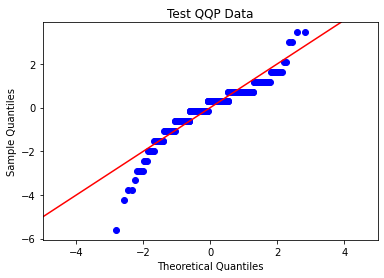

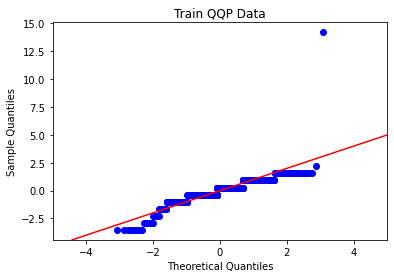

In [47]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

## Deep Dive On Residuals

In [48]:
len(df_y_test)

420

Text(0.5, 1.0, 'Residuals PDF')

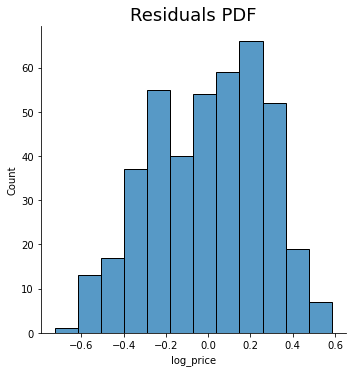

In [49]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [50]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model1, on="id")

In [51]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(50)
plotHousesWithBigErrors

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10
0,7893802670,279900.0,578093.771995,-298193.771995,298193.771995,106.535824,4/24/2015,279900.0,3,3.25,2240,5000,2.0,1540,700.0,1989,1989.0,98198,47.4114,-122.334,1800,7500,31,12.542188,0,1,0,0,0,0,1,0,0,0,0,1,0
1,8732030490,261500.0,482398.801330,-220898.801330,220898.801330,84.473729,12/22/2014,261500.0,4,2.50,2460,7800,1.0,1500,960.0,1977,1977.0,98023,47.3081,-122.384,2210,7800,43,12.474190,0,0,0,0,0,0,1,0,0,0,1,0,0
2,4136880140,254500.0,467464.226304,-212964.226304,212964.226304,83.679460,5/22/2014,254500.0,4,2.75,2570,7264,2.0,1720,850.0,1998,1998.0,98092,47.2580,-122.208,2420,7911,22,12.447056,0,0,0,0,0,0,1,0,0,0,1,0,0
3,2413300730,263500.0,479827.695931,-216327.695931,216327.695931,82.097797,9/24/2014,263500.0,4,1.75,2210,6375,1.0,1640,570.0,1977,1977.0,98003,47.3268,-122.328,2070,7210,43,12.481809,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2612000390,269950.0,483198.441757,-213248.441757,213248.441757,78.995533,6/15/2014,269950.0,3,2.50,1890,4838,2.0,1730,160.0,2002,2002.0,98168,47.4802,-122.279,1910,7409,18,12.505992,0,1,0,0,0,0,1,0,0,0,1,0,0
5,8731981640,277500.0,494235.836552,-216735.836552,216735.836552,78.103004,12/4/2014,277500.0,4,2.50,2550,7500,1.0,1750,800.0,1976,1976.0,98023,47.3165,-122.386,2260,8800,44,12.533576,0,0,0,0,0,0,1,0,0,0,1,0,0
6,8159300050,355425.0,628465.306977,-273040.306977,273040.306977,76.820794,3/12/2015,355425.0,4,2.50,3238,9112,1.0,1678,1560.0,1979,1979.0,98198,47.4005,-122.311,3056,9668,41,12.781070,0,1,0,1,0,0,0,1,0,0,1,0,0
7,9542801310,267000.0,470181.951801,-203181.951801,203181.951801,76.098109,5/13/2015,267000.0,3,2.25,2510,9900,1.0,1610,900.0,1978,1978.0,98023,47.2988,-122.374,1940,8510,42,12.495004,0,0,0,0,0,0,1,0,0,0,1,0,0
8,9264900880,263000.0,457609.822047,-194609.822047,194609.822047,73.996130,7/15/2014,263000.0,3,1.75,1790,7485,1.0,1330,460.0,1979,1979.0,98023,47.3118,-122.340,1970,8097,41,12.479909,0,0,0,0,0,0,0,1,0,0,1,0,0
9,1938400520,272000.0,471731.468691,-199731.468691,199731.468691,73.430687,10/16/2014,272000.0,4,2.25,2040,7600,1.0,1580,460.0,1978,1978.0,98023,47.3169,-122.365,2130,7200,42,12.513557,0,0,0,0,0,0,0,1,0,0,1,0,0


# <u><font color='red'>Model 2</font></u>

## Run Model

In [52]:
# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [53]:
# For SKlearn Model
model2_features_w_id = list(data_Model2.columns).copy()
model2_features_w_id = [e for e in model2_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model2_features_wo_id = list(data_Model2.columns).copy()
model2_features_wo_id = [e for e in model2_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [54]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model2, model2_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model2_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

977 420 977 420


In [55]:
df_Model2_Results_SK

,Measure,Value
0,train_R2,0.768
1,test_R2,0.770
2,train_mse,0.0233752
3,test_mse,0.0228996
4,intercept,12.6116
5,Sch_d_Top15,0.332286
6,Sch_d_Top30,0.223653
7,Sch_d_Top60,-0.0722173
8,Attractions1,0.183195
9,Over10,-0.199344


In [56]:
Model2, residuals2 = CreateModel_stats (df_y_train ,df_X_train, model2_features_wo_id)
Model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     157.8
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          5.09e-286
Time:                        21:35:16   Log-Likelihood:                 448.54
No. Observations:                 977   AIC:                            -855.1
Df Residuals:                     956   BIC:                            -752.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.6116      0.048    262.561      0.000      12.517      12.706
Sch_d_Top15       0.3323      0.014     24.107      0.000       0.305       0.359
Sch_d_Top30       0.2237      0.019     11.563      0.000       0.186       0.262
Sch_d_Top60      -0.0722      0.021     -3.441      0.001      -0.113      -0.031
Attractions1      0.1832      0.056      3.283      0.001       0.074       0.293
Over10           -0.1993      0.053     -3.728      0.000      -0.304      -0.094
Over20           -0.7285      0.075     -9.741      0.000      -0.875      -0.582
sqft_lot          0.0202      0.025      0.820      0.413      -0.028       0.068
sqft_basement     0.0877      0.041      2.125      0.034       0.007       0.169
Rooms             0.0451      0.069      0.652      0.514      -0.091       0.181
squareFt          0.8904      0.079     11.305      0.000       0.736       1.045
waterfront_1      0.1370      0.161      0.853      0.394      -0.178       0.452
view_1            0.1284      0.038      3.351      0.001       0.053       0.204
view_2            0.0611      0.024      2.567      0.010       0.014       0.108
view_3            0.1165      0.035      3.324      0.001       0.048       0.185
view_4            0.0815      0.111      0.737      0.461      -0.136       0.299
condition_4       0.0524      0.012      4.430      0.000       0.029       0.076
condition_5       0.0934      0.021      4.379      0.000       0.052       0.135
grade_8           0.1492      0.012     12.553      0.000       0.126       0.172
grade_9           0.2690      0.023     11.653      0.000       0.224       0.314
grade_10          0.1824      0.048      3.774      0.000       0.088       0.277
==============================================================================
Omnibus:                       26.152   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.159
Skew:                           0.018   Prob(JB):                     2.35e-13
Kurtosis:                       4.195   Cond. No.                         49.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking for Homoscedasticity

<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


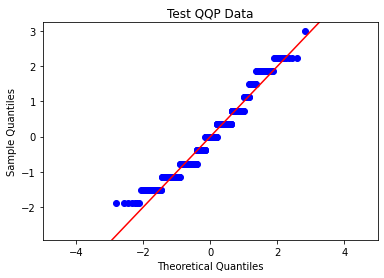

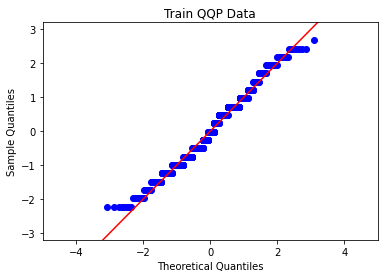

In [57]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

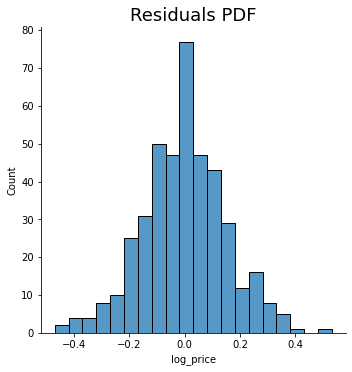

In [58]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [59]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model2, on="id")

In [60]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(5)
plotHousesWithBigErrors

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10
0,5476800069,292050.0,467016.062288,-174966.062288,174966.062288,59.909626,5/27/2014,292050.0,5,3.00,2840,7199,1.0,1710,1130.0,2003,2003.0,98178,47.5065,-122.275,2210,10800,17,12.584680,0,1,0,0,0,0,1,0,0,1,0,0,0
1,2113700360,315000.0,496177.860237,-181177.860237,181177.860237,57.516781,6/27/2014,315000.0,6,4.00,3120,4240,2.0,2090,1030.0,1993,1993.0,98106,47.5305,-122.353,1460,4240,27,12.660328,0,1,0,1,0,0,0,1,0,1,0,0,0
2,2822100175,284000.0,421211.480979,-137211.480979,137211.480979,48.313902,8/27/2014,284000.0,3,1.75,1430,4850,1.0,930,500.0,1978,1978.0,98108,47.5472,-122.303,1430,4850,42,12.556730,0,1,0,0,0,0,1,0,0,1,0,0,0
3,1565930130,429900.0,635249.299716,-205349.299716,205349.299716,47.766760,11/4/2014,429900.0,4,3.25,3760,4675,2.0,2740,1020.0,2007,2007.0,98038,47.3862,-122.048,3280,4033,13,12.971308,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2738640470,623300.0,907238.370146,-283938.370146,283938.370146,45.554046,7/16/2014,623300.0,4,3.50,4170,4524,2.0,3500,670.0,2007,2007.0,98072,47.7726,-122.162,3510,5001,13,13.342783,0,0,0,0,0,0,1,0,0,0,0,1,0


# <u><font color='red'>Model 3</font></u>

## Run Model

In [61]:
with open('regression_Data_Third_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [62]:
# For SKlearn Model
model3_features_w_id = list(data_Model3.columns).copy()
model3_features_w_id = [e for e in model3_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model3_features_wo_id = list(data_Model3.columns).copy()
model3_features_wo_id = [e for e in model3_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]

In [63]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model3, model3_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model3_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

723 311 723 311


In [64]:
df_Model3_Results_SK

,Measure,Value
0,train_R2,0.833
1,test_R2,0.816
2,train_mse,0.0168569
3,test_mse,0.0161666
4,intercept,12.762
5,Sch_d_Top15,0.228294
6,Sch_d_Top30,0.129284
7,Sch_d_Top60,-0.0663574
8,Attractions1,-0.0115571
9,Over10,-0.208604


In [65]:
df_y_train.shape

(723,)

In [66]:
Model3, residuals3 = CreateModel_stats (df_y_train ,df_X_train, model3_features_wo_id)
Model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     174.9
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          1.03e-256
Time:                        21:35:17   Log-Likelihood:                 450.11
No. Observations:                 723   AIC:                            -858.2
Df Residuals:                     702   BIC:                            -762.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7620      0.052    246.625      0.000      12.660      12.864
Sch_d_Top15        0.2283      0.014     16.264      0.000       0.201       0.256
Sch_d_Top30        0.1293      0.020      6.508      0.000       0.090       0.168
Sch_d_Top60       -0.0664      0.019     -3.414      0.001      -0.105      -0.028
Attractions1      -0.0116      0.060     -0.194      0.846      -0.128       0.105
Over10            -0.2086      0.057     -3.691      0.000      -0.320      -0.098
Over20            -0.7209      0.083     -8.669      0.000      -0.884      -0.558
view_1             0.0614      0.039      1.573      0.116      -0.015       0.138
view_2             0.0221      0.027      0.828      0.408      -0.030       0.074
view_3             0.0383      0.032      1.203      0.229      -0.024       0.101
view_4             0.0455      0.095      0.480      0.631      -0.141       0.232
condition_4       -0.0052      0.012     -0.446      0.656      -0.028       0.018
condition_5        0.0531      0.022      2.385      0.017       0.009       0.097
grade_8            0.0900      0.013      7.191      0.000       0.065       0.115
grade_9            0.1302      0.024      5.423      0.000       0.083       0.177
grade_10           0.1200      0.046      2.604      0.009       0.030       0.210
sqft_lot          -0.0268      0.025     -1.060      0.289      -0.077       0.023
sqft_basement      0.0859      0.043      2.004      0.045       0.002       0.170
Rooms              0.0904      0.070      1.299      0.194      -0.046       0.227
squareFt           0.3711      0.073      5.076      0.000       0.228       0.515
AppraisedValue     1.2544      0.078     16.112      0.000       1.102       1.407
==============================================================================
Omnibus:                       29.443   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.945
Skew:                          -0.250   Prob(JB):                     2.61e-13
Kurtosis:                       4.294   Cond. No.                         35.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking for Homoscedasticity

<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-40-73f554ed55de>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


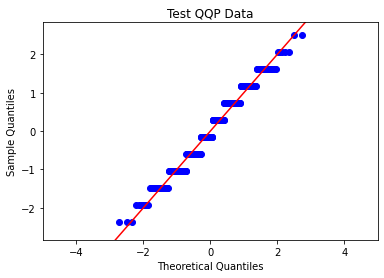

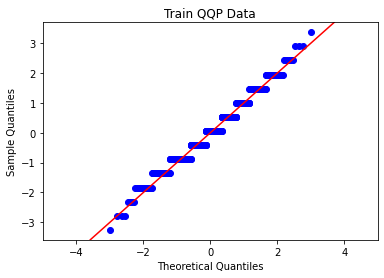

In [67]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

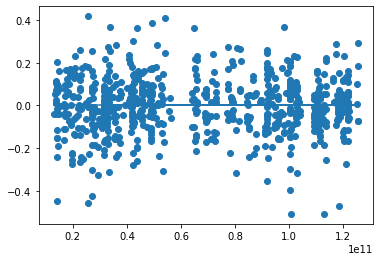

In [68]:
plt.scatter(Model3.predict(df_X_train), Model3.resid)
plt.plot(Model3.predict(df_X_train), [0 for i in range(len(df_X_train))]);

## Backword Elimination

In [69]:
model3_features_wo_id

['Sch_d_Top15',
 'Sch_d_Top30',
 'Sch_d_Top60',
 'Attractions1',
 'Over10',
 'Over20',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_8',
 'grade_9',
 'grade_10',
 'sqft_lot',
 'sqft_basement',
 'Rooms',
 'squareFt',
 'AppraisedValue']

In [70]:
#Backward Elimination
df_y_train ,df_X_train, model3_features_wo_id

# y = df['msrp']
y = df_y_train
cols = model3_features_wo_id
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = df_X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
# print(selected_features_BE)
df_final_Features = p.to_frame("Pvalue")
df_final_Features.index.name = 'Features'
df_final_Features

,Pvalue
Features,
Sch_d_Top15,3.036886e-51
Sch_d_Top30,5.535652e-15
Sch_d_Top60,2.731535e-04
Over10,2.010711e-05
Over20,1.502928e-38
condition_5,2.172557e-02
grade_8,3.806640e-13
grade_9,1.272707e-08
grade_10,1.185171e-02


## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

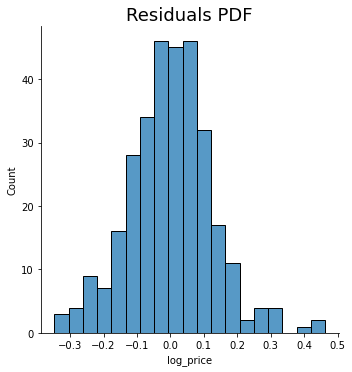

In [71]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [72]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model3, on="id")

In [73]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(50)
plotHousesWithBigErrors

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10
0,4279900140,251000.0,355004.172610,-104004.172610,104004.172610,41.435925,10/1/2014,251000.0,4,2.00,1650,5974,1.0,860,790.0,1972,1972.0,98178,47.5008,-122.257,1940,6001,48,12.433208,0,1,0,0,0,0,0,0,1,1,0,0,0
1,5476800069,292050.0,410861.810220,-118811.810220,118811.810220,40.682010,5/27/2014,292050.0,5,3.00,2840,7199,1.0,1710,1130.0,2003,2003.0,98178,47.5065,-122.275,2210,10800,17,12.584680,0,1,0,0,0,0,1,0,0,1,0,0,0
2,3331000070,735000.0,462988.604043,272011.395957,272011.395957,37.008353,6/6/2014,735000.0,4,2.50,2820,6180,2.0,2050,770.0,2013,2013.0,98118,47.5529,-122.281,1390,4635,7,13.507626,0,1,0,0,0,0,1,0,0,0,0,1,0
3,9211500620,305000.0,193228.330597,111771.669403,111771.669403,36.646449,4/28/2015,305000.0,3,2.25,1740,6650,1.0,1240,500.0,1978,1978.0,98023,47.2979,-122.379,1740,7000,42,12.628067,0,0,0,0,0,0,1,0,0,1,0,0,0
4,2822100175,284000.0,385048.766871,-101048.766871,101048.766871,35.580552,8/27/2014,284000.0,3,1.75,1430,4850,1.0,930,500.0,1978,1978.0,98108,47.5472,-122.303,1430,4850,42,12.556730,0,1,0,0,0,0,1,0,0,1,0,0,0
5,9407110710,322000.0,211900.350295,110099.649705,110099.649705,34.192438,2/26/2015,322000.0,3,1.75,1510,8400,1.0,980,530.0,1979,1979.0,98045,47.4476,-121.771,1500,10125,41,12.682307,0,0,0,0,0,0,0,0,0,1,0,0,0
6,3810000202,251700.0,337576.751230,-85876.751230,85876.751230,34.118693,9/5/2014,251700.0,3,2.25,1810,11800,1.0,1240,570.0,1977,1977.0,98178,47.4997,-122.231,1810,5641,43,12.435993,0,1,0,0,0,0,1,0,0,1,0,0,0
7,7575620120,260000.0,347004.249364,-87004.249364,87004.249364,33.463173,4/22/2015,260000.0,3,3.00,2390,8993,2.0,1680,710.0,1988,1988.0,98003,47.3532,-122.306,1820,10362,32,12.468437,0,0,0,0,0,0,1,0,0,0,1,0,0
8,7016310030,330000.0,439741.808754,-109741.808754,109741.808754,33.255094,2/19/2015,330000.0,4,2.50,2180,7210,1.0,1190,990.0,1972,1972.0,98011,47.7419,-122.181,2070,7210,48,12.706848,0,0,0,0,0,0,1,0,0,1,0,0,0
9,1545805030,266500.0,347156.309680,-80656.309680,80656.309680,30.265032,10/21/2014,266500.0,3,2.25,1740,5460,1.0,1210,530.0,1998,1998.0,98038,47.3648,-122.046,1740,7500,22,12.493130,0,0,0,0,0,0,1,0,0,1,0,0,0


# <u><font color='blue'>3 Models Side By Side</font></u>

In [74]:
listofModels = []
listofModels.append(df_Model1_Results_SK)
listofModels.append(df_Model2_Results_SK)
listofModels.append(df_Model3_Results_SK)
display_side_by_side_withNames(listofModels, names=["Model1", "Model2", "Model3"])

Model1,Model2,Model3
,Measure,Value
0,train_R2,0.384
1,test_R2,0.306
2,train_mse,0.061774
3,test_mse,0.0696841
4,intercept,12.6279
5,waterfront_1,-0.0385994
6,view_1,0.147277
7,view_2,0.0734055
8,view_3,0.0254936


In [75]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
resid1 = durbin_watson(residuals1)
resid2 = durbin_watson(residuals2)
resid3 = durbin_watson(residuals3)

df = pd.DataFrame([resid1, resid2,resid3], index =['1', '2', '3'], 
                                              columns =['Durbin-Watson']) 
df 

,Durbin-Watson
1,2.102313
2,1.975022
3,1.900109


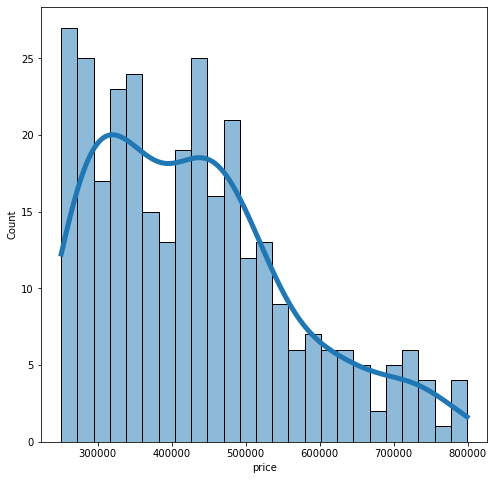

In [76]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=CheckForResiduals_No_Dummies,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax,)
plt.show()

In [78]:
selected_features_BE

['Sch_d_Top15',
 'Sch_d_Top30',
 'Sch_d_Top60',
 'Over10',
 'Over20',
 'condition_5',
 'grade_8',
 'grade_9',
 'grade_10',
 'sqft_basement',
 'squareFt',
 'AppraisedValue']

In [79]:
Model4, residuals4 = CreateModel_stats (df_y_train ,df_X_train, selected_features_BE)
Model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     291.0
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          1.40e-264
Time:                        21:39:31   Log-Likelihood:                 446.27
No. Observations:                 723   AIC:                            -866.5
Df Residuals:                     710   BIC:                            -807.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7442      0.026    499.027      0.000      12.694      12.794
Sch_d_Top15        0.2244      0.014     16.351      0.000       0.197       0.251
Sch_d_Top30        0.1404      0.018      7.988      0.000       0.106       0.175
Sch_d_Top60       -0.0702      0.019     -3.658      0.000      -0.108      -0.033
Over10            -0.2022      0.047     -4.293      0.000      -0.295      -0.110
Over20            -0.7180      0.052    -13.800      0.000      -0.820      -0.616
condition_5        0.0498      0.022      2.300      0.022       0.007       0.092
grade_8            0.0908      0.012      7.402      0.000       0.067       0.115
grade_9            0.1364      0.024      5.757      0.000       0.090       0.183
grade_10           0.1154      0.046      2.523      0.012       0.026       0.205
sqft_basement      0.1048      0.039      2.655      0.008       0.027       0.182
squareFt           0.4237      0.065      6.561      0.000       0.297       0.551
AppraisedValue     1.2515      0.076     16.492      0.000       1.103       1.401
==============================================================================
Omnibus:                       23.741   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.017
Skew:                          -0.216   Prob(JB):                     4.56e-10
Kurtosis:                       4.114   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Misc Code To Keep For Now

In [ ]:
# For Export If Required
# CheckForResiduals_No_Dummies.to_excel("CheckForResiduals_No_Dummies.xlsx")
# CheckForResiduals_with_Dummies.to_excel("CheckForResiduals_with_Dummies.xlsx")

In [ ]:
#for additional chekcing if requires
#df_check2 = CheckForResiduals_No_Dummies.loc[CheckForResiduals_No_Dummies.id ==7950304095]
#df_check2

In [ ]:
# For addiontal chekcing
# import warnings
# warnings.filterwarnings('ignore')
# fig = plt.figure(figsize = (15,15))
# # fig.tight_layout(pad=10.0)
# ax = fig.gca()
# sns.set(font_scale=1)
# plotHousesWithBigErrors.hist(ax = ax, label='small');
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.subplots_adjust(hspace = 0.8)
# plt.show()